<h1><center> SF DS Final Project </center></h1>
<h2><center> Microbusiness Density Forecasting from Kaggle </center></h2>


## Goal of the Competition
The goal of this competition is to predict monthly microbusiness density in a given area. You will develop an accurate model trained on U.S. county-level data.

Your work will help policymakers gain visibility into microbusinesses, a growing trend of very small entities. Additional information will enable new policies and programs to improve the success and impact of these smallest of businesses.

## Context
American policy leaders strive to develop economies that are more inclusive and resilient to downturns. They're also aware that with advances in technology, entrepreneurship has never been more accessible than it is today. Whether to create a more appropriate work/life balance, to follow a passion, or due to loss of employment, studies have demonstrated that Americans increasingly choose to create businesses of their own to meet their financial goals. The challenge is that these "microbusinesses" are often too small or too new to show up in traditional economic data sources, making it nearly impossible for policymakers to study them. But data science could help fill in the gaps and provide insights into the factors associated these businesses.

Current models leverage available internal and census data, use econometric approaches, and focus on understanding primary determinants. While these methods are adequate, there's potential to include additional data and using more advanced approaches to improve predictions and to better inform decision-making.

Competition host GoDaddy is the world’s largest services platform for entrepreneurs around the globe. They're on a mission to empower their worldwide community of 20+ million customers—and entrepreneurs everywhere—by giving them all the help and tools they need to grow online.

Your work will help better inform policymakers as they strive to make the world a better place for microbusiness entrepreneurs. This will have a real and substantial impact on communities across the country and will help our broader economy adapt to a constantly evolving world.

# **Adjustments** 

For convenience within the course project, I will only use a random subsample of the whole dataset. 

In [349]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import random


import sklearn
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

In [350]:
# Global setting 
validate = True

# Validation size = 3 month
cutoff = 3

# models
# if model is True then it will be used, if not then it will be skipped to save time 

m_AR = True # Auto Regressive
m_ARIMA = True # Auto Regressive Integrated Moving Average
m_auto_arima = True # Auto Arima
m_Prophet = True #  Prophet


In [351]:
# Path to data 

census_file_name = 'data/census_starter.csv'
train_file_name = 'data/train.csv'
test_file_name = 'data/test.csv'

In [352]:
# Evaluation metric is SMAPE https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
def smape(y_true, y_pred):
    num = np.abs(y_true - y_pred)
    den = (np.abs(y_true) + np.abs(y_pred)) /2 
    return 100 * np.mean(num/den)

# Data loading

- *row_id* - An ID code for the row.
- *cfips* - A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.
- *county_name* - The written name of the county.
- *state_name* - The name of the state.
- *first_day_of_month* - The date of the first day of the month.
- *microbusiness_density* - Microbusinesses per 100 people over the age of 18 in the given county. This is the target variable. The population figures used to calculate the density are on a two-year lag due to the pace of update provided by the U.S. Census Bureau, which provides the underlying population data annually. 2021 density figures are calculated using 2019 population figures, etc.
- *active* - The raw count of microbusinesses in the county. Not provided for the test set.

In [353]:
df = pd.read_csv(train_file_name)
print(df.shape)
df.head(2)

(122265, 7)


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198


In [354]:
# pick random sample of counties from df of size 300

random.seed(100)
sample = random.sample(list(df['cfips'].unique()), 300)

train_df = df[df['cfips'].isin(sample)]
train_df.shape


(11700, 7)

The data is already relatively clean and therefore, does not require pre-processing.

## External data sources

US Census (provided by Kaggle):

- cfips - The CFIPS code (primary key)
- pct_bb_[year] - The percentage of households in the county with access to broadband of any type. Derived from ACS table B28002: PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD.
- pct_college_[year] - The percent of the population in the county over age 25 with a 4-year college degree. Derived from ACS table S1501: EDUCATIONAL ATTAINMENT.
- pct_foreign_born_[year] - The percent of the population in the county born outside of the United States. Derived from ACS table DP02: SELECTED SOCIAL CHARACTERISTICS IN THE UNITED STATES.
- pct_it_workers_[year] - The percent of the workforce in the county employed in information related industries. Derived from ACS table S2405: INDUSTRY BY OCCUPATION FOR THE CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER.
- median_hh_inc_[year] - The median household income in the county. Derived from ACS table S1901: INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS)

The data is on county-year level. Since we have data on county-month level incorporating it in the model is not straightforward.

In [355]:
census = pd.read_csv(census_file_name)
print(census.shape)
census.head(2)

(3142, 26)


,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0


In [356]:
census.index = census['cfips']
census = pd.wide_to_long(census, ["pct_bb_", "pct_college_", "pct_it_workers_", "median_hh_inc_", "pct_foreign_born_"], i="cfips", j="year")
census['cfips'] = census.index.get_level_values(0)
census['year'] = census.index.get_level_values(1)
census['year']= pd.to_datetime(census['year'], format='%Y')
census.head(2)

,,pct_bb_,pct_college_,pct_it_workers_,median_hh_inc_,pct_foreign_born_,cfips,year
cfips,year,,,,,,,
1001,2017,76.6,14.5,1.3,55317.0,2.1,1001,2017-01-01
1003,2017,74.5,20.4,1.4,52562.0,3.2,1003,2017-01-01


In [357]:
# train_df = train_df.merge(census, on='cfips', how='left')
# train_df.head(10)

# EDA

For training we have a balanced panel on monthly - county level with 122265 observations. Each county is observed 39 times. 

In [358]:
# Time frame of the trainig data

print('Train data description:')
# convert to datetime
train_df["first_day_of_month"] = pd.to_datetime(train_df["first_day_of_month"])
print('The start date is', train_df["first_day_of_month"].min().date() , 'the end date is', train_df["first_day_of_month"].max().date())
# Unique counties and states
print('There are', train_df['cfips'].nunique(), 'counties in', train_df['state'].nunique(), 'states in the dataset.')

# Obs. per county
if train_df.cfips.value_counts().min() ==  train_df.cfips.value_counts().max():
    print('The panel is balanced - all counties have the same number of observations: ', train_df.cfips.value_counts().min())
else:
    print('The panel is unbalanced - counties have different number of observations with min', train_df.cfips.value_counts().min(), ' and max ',  train_df.cfips.value_counts().max() )


Train data description:
The start date is 2019-08-01 the end date is 2022-10-01
There are 300 counties in 46 states in the dataset.
The panel is balanced - all counties have the same number of observations:  39


In [359]:
# Census data description

print('Census data description:')
# Unique counties and states
print('There are', census['cfips'].nunique(), 'counties.')


Census data description:
There are 3142 counties.


## Target EDA

The target variable is microbusiness density defined as number of business per 100 people over the age of 18 in the given county. 

**Summary:**

- On average there are 4 microbusinesses per 100 people. 
- On average across observed counties microbusiness density increases, i.e. microbusiness sector of economy develops.
- Most of the values are concentrated within the range between 0 and 10, yet some extreme values are observed. The ddistribution is skewed to the right.

In [360]:
train_df['microbusiness_density'].describe()

count    11700.000000
mean         4.051037
std          3.835456
min          0.322997
25%          1.666344
50%          2.819223
75%          5.397125
max         47.399479
Name: microbusiness_density, dtype: float64

''

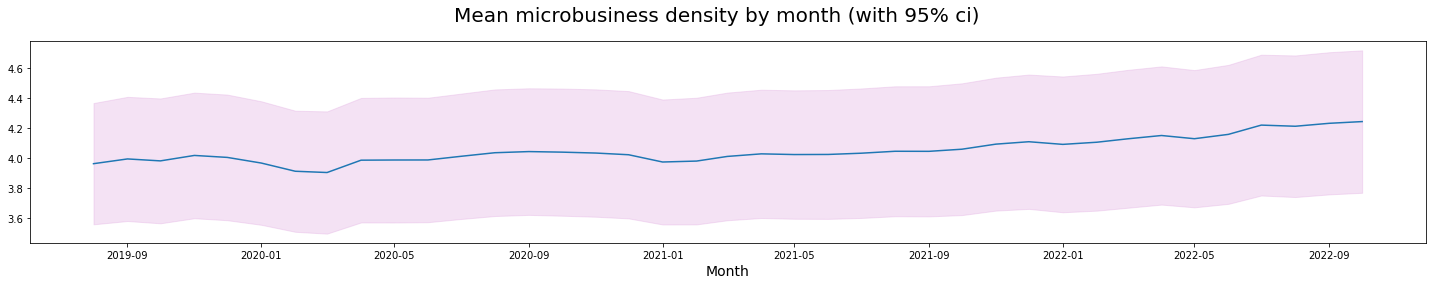

In [361]:
mean = train_df.groupby('first_day_of_month')['microbusiness_density'].mean()
sd = train_df.groupby('first_day_of_month')['microbusiness_density'].std()
ci = 1.96 * sd/np.sqrt(train_df['cfips'].nunique()) 

fig, ax = plt.subplots(figsize=(20,4))
ax.plot(train_df['first_day_of_month'].unique() , mean)
ax.fill_between(train_df['first_day_of_month'].unique(), (mean-ci), (mean+ci), color='plum', alpha=.3)
fig.suptitle('Mean microbusiness density by month (with 95% ci)', fontsize=20)
ax.set_xlabel('Month', fontsize = 14)
plt.tight_layout()
;

''

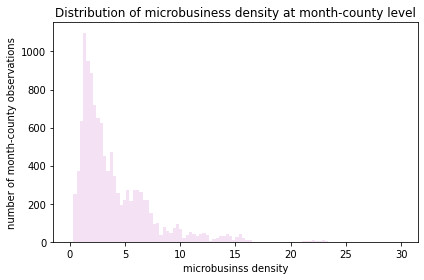

In [362]:
plt.hist(train_df.microbusiness_density, bins=100, range=(0,30), color='plum', alpha=.3)
plt.xlabel('microbusinss density')
plt.ylabel('number of month-county observations')
plt.title('Distribution of microbusiness density at month-county level')
plt.tight_layout()
;

''

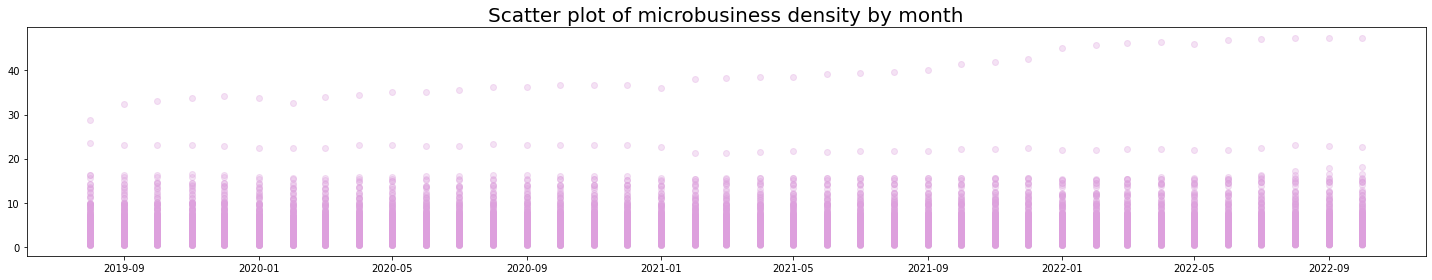

In [363]:
fig, ax = plt.subplots(figsize=(20,4))
plt.scatter(data=train_df, x="first_day_of_month", y="microbusiness_density", color='plum', alpha=.3)
plt.title('Scatter plot of microbusiness density by month', fontsize=20)
plt.tight_layout()
;

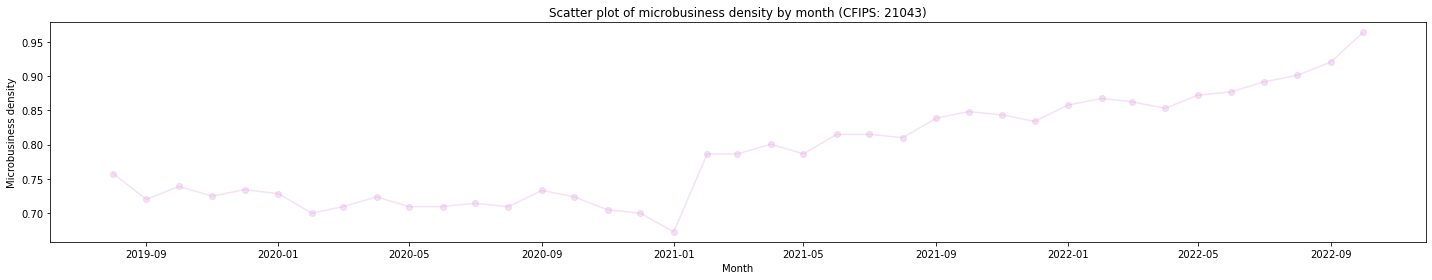

In [364]:
# visualize one county 

def plotCounty(county):
    data=train_df[train_df['cfips'] == county]
    fig, ax = plt.subplots(figsize=(20,4))
    plt.plot(data["first_day_of_month"], data["microbusiness_density"],'-o', color='plum', alpha=.3)
    plt.title(f'Scatter plot of microbusiness density by month (CFIPS: {county})')
    plt.ylabel('Microbusiness density')
    plt.xlabel('Month')
    plt.tight_layout()

np.random.seed(42)
county = int(np.random.choice(train_df['cfips'].unique().tolist(), 1) )   
plotCounty(county)

## Statistical analysis

County:  21043
non stationary, try differencing
adf:  -7.500174274862336
p-value:  4.274195840236645e-11
Critical values:  {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}
The first differences are stationary


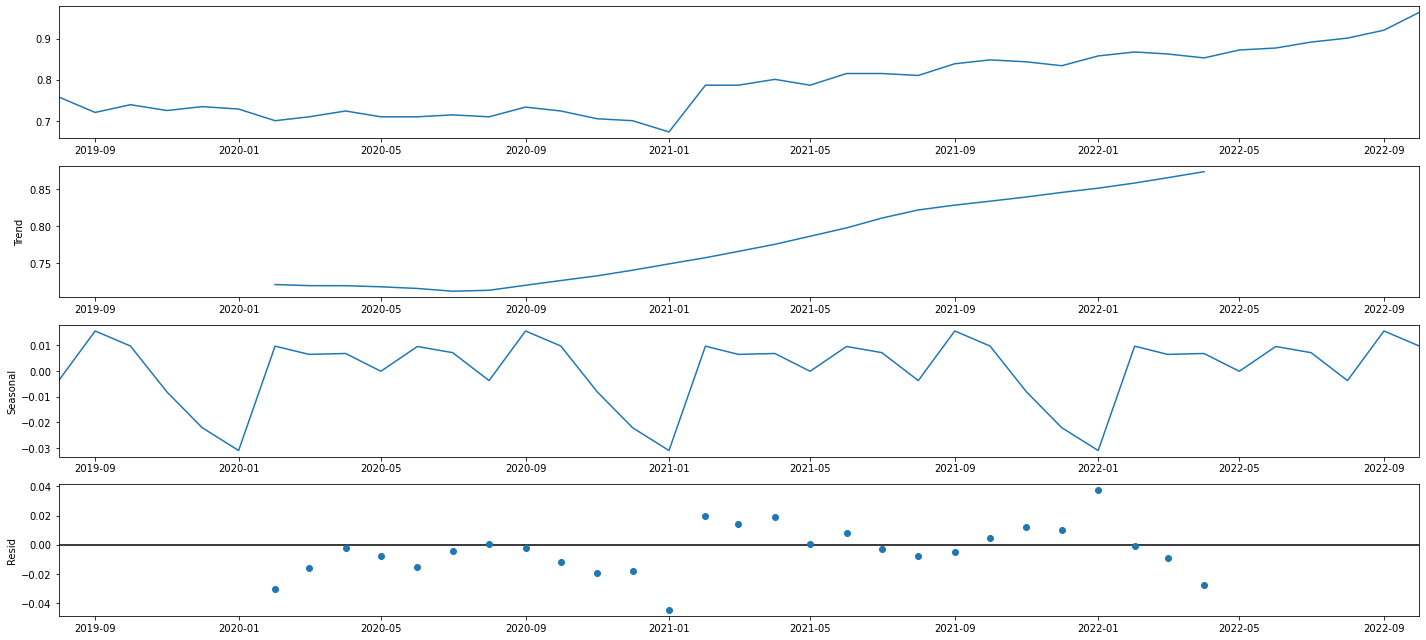

In [365]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
# First, we look at the seasonal decomposition of one county and test for stationarity
def plotSeasonalDec(county):
    print('County: ', county)
    data = train_df[train_df['cfips'] == county][['microbusiness_density', 'first_day_of_month']]
    # convert data to time series
    tdi = pd.DatetimeIndex(data['first_day_of_month'])
    data.set_index(tdi, inplace=True)
    data.drop(columns='first_day_of_month', inplace=True)
    data.index.name = 'datetimeindex'
    
    test = adfuller(data.values)

    if test[0]> test[4]['5%']: 
        print('non stationary, try differencing')
        # try differencing 
        df_diff_1 = data.diff(periods=1).dropna()
        test1 = adfuller(df_diff_1)
        print ('adf: ', test1[0])
        print ('p-value: ', test1[1])
        print ('Critical values: ', test1[4])
        if test1[0]> test1[4]['5%']: 
            print ('non stationary')
        else:
            print ('The first differences are stationary')
    else:
        print ('adf: ', test[0])
        print ('p-value: ', test[1])
        print ('Critical values: ', test[4])
        print ('stationary')
    
    decomposition = seasonal_decompose(data)
    fig = decomposition.plot()
    fig.set_size_inches((20, 9))
    plt.tight_layout()
    plt.show()

np.random.seed(42)
county = int(np.random.choice(train_df['cfips'].unique().tolist(), 1) )   
plotSeasonalDec(county)

- We observe the upcoming trend 
- The seasonality is not very clear, but we can see that the density is higher in the summer months

County:  21043


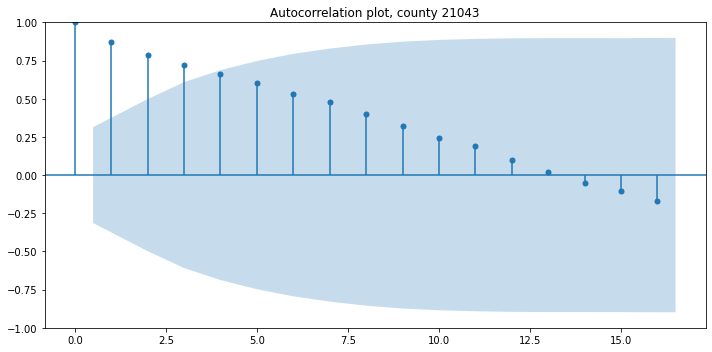

In [366]:
# plot autocorrelation for one county
from statsmodels.graphics.tsaplots import plot_acf

def plotAutocorr(county):
    print('County: ', county)
    data = train_df[train_df['cfips'] == county][['microbusiness_density', 'first_day_of_month']]
    # convert data to time series
    tdi = pd.DatetimeIndex(data['first_day_of_month'])
    data.set_index(tdi, inplace=True)
    data.drop(columns='first_day_of_month', inplace=True)
    data.index.name = 'datetimeindex'
    
    decomposition = seasonal_decompose(data)
    fig = plot_acf(data)
    fig.set_size_inches((10, 5))
    plt.tight_layout()
    plt.title(f'Autocorrelation plot, county {county}' )
    plt.show()

np.random.seed(42)
county = int(np.random.choice(train_df['cfips'].unique().tolist(), 1) )   
plotAutocorr(county)

County:  21043


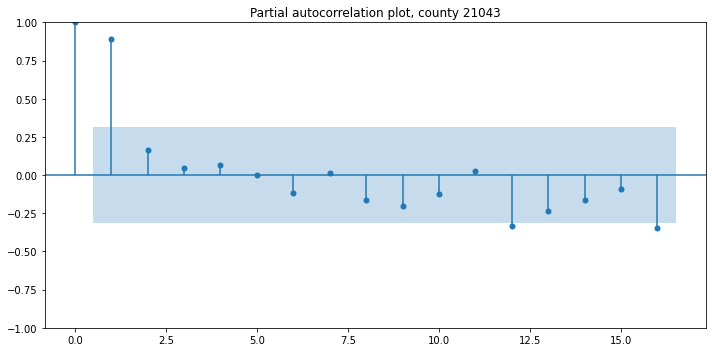

In [367]:
# Partial autocorrelation plot

from statsmodels.graphics.tsaplots import plot_pacf

def plotPAutocorr(county):
    print('County: ', county)
    data = train_df[train_df['cfips'] == county][['microbusiness_density', 'first_day_of_month']]
    # convert data to time series
    tdi = pd.DatetimeIndex(data['first_day_of_month'])
    data.set_index(tdi, inplace=True)
    data.drop(columns='first_day_of_month', inplace=True)
    data.index.name = 'datetimeindex'
    
    decomposition = seasonal_decompose(data)
    fig = plot_pacf(data)
    fig.set_size_inches((10, 5))
    plt.tight_layout()
    plt.title(f'Partial autocorrelation plot, county {county}' )
    plt.show()

np.random.seed(42)
county = int(np.random.choice(train_df['cfips'].unique().tolist(), 1) )   
plotPAutocorr(county)

- Parameter p for AR model can be chosen based on the partial autocorrelation plot. In this case, p = 2.

# Modeling 
I do not use SMA or EMA since the goal of the project is not only short-term predictions. 

First I assume that model parameters are homogeneous across the counties and later on I relax this assumption. 

- Since we have many counties and some series are stationary but some are not, I begin with simple AR model and ARIMA. 
- Later on, to auto ARIMA as choosing parameters for each and every county is tidious.
- Lastly, I use completely automated model - Prophet

In [368]:
from datetime import date, datetime
from dateutil.relativedelta import relativedelta

# function to create row_id based on the forecast id and county
start = min(train_df['first_day_of_month'])
def row_id(row, county):
    return str(county) + '_' + str((start + relativedelta(months=+row)).date())


def get_submission(ids, y_preds):
    df_pred = pd.DataFrame(columns=['row_id', 'microbusiness_density'])
    df_pred['row_id'] = ids
    df_pred['microbusiness_density'] = y_preds
    df_pred['date'] = pd.to_datetime(df_pred['row_id'].apply(lambda x: x.split('_')[1]))
    df_pred['cfips'] = df_pred['row_id'].apply(lambda x: int(x.split('_')[0]))
    df_pred.sort_values(by=['date', 'cfips'], inplace=True)
    df_pred.drop(['date', 'cfips'], axis=1, inplace=True)
    df_pred = df_pred.reset_index(drop=True)
    return df_pred

## AR

In [370]:
from statsmodels.tsa.ar_model import AutoReg as AR

if m_AR: 
    
    if validate: 
        cutoff_month = train_df['first_day_of_month'].unique()[-cutoff]
        X_train = train_df[train_df['first_day_of_month'] < cutoff_month]
    
    else:
        X_train = train_df
        
    p = 2 # number of lags

    y_preds = []
    ids = []

    for county in X_train['cfips'].unique():
        data = X_train[X_train['cfips'] == county].reset_index(drop = True)
        y_pred = AR(data['microbusiness_density'], lags=p).fit().forecast(8)
        for row in y_pred.index:
            ids.append(row_id(row, county))
            y_preds.append(y_pred[row])

    df_pred = get_submission(ids, y_preds)

    if validate:
        df_pred = pd.merge(df_pred, train_df[['row_id', 'microbusiness_density']], on = 'row_id', how = 'left' ).head(10)
        df_pred.columns = ['row_id', 'microbusiness_density', 'true']
        smape_ar = smape(df_pred['true'], df_pred['microbusiness_density'])
        print('SMAPE: ', smape_ar)
    else: 
        print(df_pred.head(2))
        df_pred.to_csv("submission_ar.csv", index=False)


SMAPE:  2.1129742810153505


## ARIMA

In [371]:
from statsmodels.tsa.arima.model import ARIMA

if m_ARIMA:
    order = (2, 1, 2) # auroregressive, differencing, moving average

    if validate: 
        cutoff_month = train_df['first_day_of_month'].unique()[-cutoff]
        X_train = train_df[train_df['first_day_of_month'] < cutoff_month]
        
    else:
        X_train = train_df

    y_preds = []
    ids = []

    for county in X_train['cfips'].unique():
        data = X_train[X_train['cfips'] == county].reset_index(drop = True)
        y_pred = ARIMA(data['microbusiness_density'], order = order).fit().forecast(8)
        for row in y_pred.index:
            ids.append(row_id(row, county))
            y_preds.append(y_pred[row])

    df_pred = get_submission(ids, y_preds)

    if validate:
        df_pred = pd.merge(df_pred, train_df[['row_id', 'microbusiness_density']], on = 'row_id', how = 'left' )
        df_pred.columns = ['row_id', 'microbusiness_density', 'true']
        smape_arima  = smape(df_pred['true'], df_pred['microbusiness_density'])
        print('SMAPE: ', smape_arima )
    else: 
        print(df_pred.head(2))
        df_pred.to_csv("submission_arima.csv", index=False)


SMAPE:  2.1299545442922856


## AUTO ARIMA

In [372]:
from pmdarima.arima import auto_arima

if m_auto_arima:

    if validate: 
        cutoff_month = train_df['first_day_of_month'].unique()[-cutoff]
        X_train = train_df[train_df['first_day_of_month'] < cutoff_month]
        
    else:
        X_train = train_df

    y_preds = []
    ids = []

    for county in X_train['cfips'].unique():
        data = X_train[X_train['cfips'] == county].reset_index(drop = True)
        m = auto_arima(data['microbusiness_density'], start_p=1, start_q=1,
                    test='adf',             # use adftest to find optimal 'd'
                    max_p=3, max_q=3,           # maximum p and q
                    m=1,                        # frequency of series
                    d=None,                     # let model determine 'd'
                    seasonal=True,              # Seasonality
                    start_P=0,
                    D=0,
                    trace=True,
                    stepwise=True)
                        
        m.fit(data['microbusiness_density'])             
        y_pred = m.predict(cutoff)
        for row in y_pred.index:
                ids.append(row_id(row, county))
                y_preds.append(y_pred[row])

    df_pred = get_submission(ids, y_preds)

    if validate:
       df_pred = pd.merge(df_pred, train_df[['row_id', 'microbusiness_density']], on = 'row_id', how = 'left' )
       df_pred.columns = ['row_id', 'microbusiness_density', 'true']
       smape_auto_arima  = smape(df_pred['true'], df_pred['microbusiness_density'])
       print('SMAPE: ', smape_auto_arima)
    else: 
       print(df_pred.head(2))
       df_pred.to_csv("submission_auto_arima.csv", index=False)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-114.660, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-118.587, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-116.659, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-116.661, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-115.087, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.217 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-104.020, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-87.932, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-94.969, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-106.060, Time=0.10 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-104.081, Time=0.18 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-104.130, Time=0.11 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total

## Prophet

In [373]:
from prophet import Prophet

if m_Prophet:

    y_preds = []
    ids = []

    for county in X_train['cfips'].unique():
        
        m = Prophet()
        
        data = X_train[X_train['cfips'] == county].reset_index(drop = True)
        data =data[['first_day_of_month', 'microbusiness_density']]
        data.columns = ['ds', 'y']  
        m.fit(data)
        future = m.make_future_dataframe(periods=cutoff)
        forecast = m.predict(future)
        y_pred = forecast['trend'][-cutoff:]
        for row in y_pred.index:
            ids.append(row_id(row, county))
            y_preds.append(y_pred[row])

    
    df_pred = get_submission(ids, y_preds)

    if validate:
        df_pred = pd.merge(df_pred, train_df[['row_id', 'microbusiness_density']], on = 'row_id', how = 'left' ).head(10)
        df_pred.columns = ['row_id', 'microbusiness_density', 'true']
        smape_p = smape(df_pred['true'], df_pred['microbusiness_density'])
        print('SMAPE: ', smape_p)
    else: 
        print(df_pred.head(2))
        df_pred.to_csv("submission_prophet.csv", index=False)


13:49:56 - cmdstanpy - INFO - Chain [1] start processing
13:49:57 - cmdstanpy - INFO - Chain [1] done processing
13:49:57 - cmdstanpy - INFO - Chain [1] start processing
13:49:57 - cmdstanpy - INFO - Chain [1] done processing
13:49:58 - cmdstanpy - INFO - Chain [1] start processing
13:49:58 - cmdstanpy - INFO - Chain [1] done processing
13:49:59 - cmdstanpy - INFO - Chain [1] start processing
13:49:59 - cmdstanpy - INFO - Chain [1] done processing
13:50:00 - cmdstanpy - INFO - Chain [1] start processing
13:50:00 - cmdstanpy - INFO - Chain [1] done processing
13:50:01 - cmdstanpy - INFO - Chain [1] start processing
13:50:01 - cmdstanpy - INFO - Chain [1] done processing
13:50:01 - cmdstanpy - INFO - Chain [1] start processing
13:50:02 - cmdstanpy - INFO - Chain [1] done processing
13:50:02 - cmdstanpy - INFO - Chain [1] start processing
13:50:02 - cmdstanpy - INFO - Chain [1] done processing
13:50:03 - cmdstanpy - INFO - Chain [1] start processing
13:50:27 - cmdstanpy - INFO - Chain [1]

SMAPE:  5.700666181207875


# Conclusion



In [374]:
# compare models

print('AR SMAPE: ', smape_ar)
print('ARIMA SMAPE: ', smape_arima)
print('Auto ARIMA SMAPE: ', smape_auto_arima)
print('Prophet SMAPE: ', smape_p)

AR SMAPE:  2.1129742810153505
ARIMA SMAPE:  2.1299545442922856
Auto ARIMA SMAPE:  2.472205416184958
Prophet SMAPE:  5.700666181207875


Out of the 4 model AR is chosen based on the performance metric SMAPE.

Further improvements of the model: 

- incorporate additional data sources on yearly level
- include geospatial elements, i.e. take into account the neighbouring counties